In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import impedance

from impedance.visualization import plot_nyquist
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.validation import linKK
from sklearn.linear_model import LinearRegression

In [2]:
#Converts text file exported from Biologic into form ready for preprocessing

data = '1047_EIS_C03.txt'

df = pd.read_csv(data, sep="\t", encoding= 'unicode_escape')
df1 = df.iloc[:, 0:3] 
df1 = df1.rename(columns={'freq/Hz': 'freq_Hz', 'Re(Z)/Ohm':'Re_Z_Ohm', '-Im(Z)/Ohm':'Im_Z_Ohm'}) 

df1.Im_Z_Ohm = df1.Im_Z_Ohm*-1
df1.to_csv("data.csv", index = False)


In [3]:
#Formats dataframe for impedance fitting and analysis

freq, Z = preprocessing.readCSV('./data.csv')

#This Biologic prepreprocessing code does not work.
#freq, Z = preprocessing.readBioLogic('./319_02_PEIS_CF1.mpr')

#This part seems to get rid of NaN values
freq, Z = preprocessing.cropFrequencies(freq, Z, freqmin=0, freqmax=None)




In [4]:
#Get reasonable initial guess values for high frequency resistance and Rion (from Gasteiger blocking model)

#Adjust to get linear high freq. region
Z_Re_highf = Z.real[8:15]
Z_Im_highf = Z.imag[8:15]

#Adjust to get linear low freq. region
Z_Re_lowf = Z.real[-18:-10]
Z_Im_lowf = Z.imag[-18:-10]

Z_Re_highf = Z_Re_highf.reshape(len(Z_Re_highf),1)
Z_Im_highf = Z_Im_highf.reshape(len(Z_Im_highf),1)
Z_Re_lowf = Z_Re_lowf.reshape(len(Z_Re_lowf),1)
Z_Im_lowf = Z_Im_lowf.reshape(len(Z_Im_lowf),1)

Z_highf = LinearRegression().fit(Z_Re_highf, Z_Im_highf)
Z_lowf = LinearRegression().fit(Z_Re_lowf, Z_Im_lowf)

Z_highf_m = np.float(Z_highf.coef_)
Z_highf_c = np.float(Z_highf.intercept_)
Z_lowf_m = np.float(Z_lowf.coef_)
Z_lowf_c = np.float(Z_lowf.intercept_)

#R_highf and Rlowf is the x-axis intercept, i.e. high frequency resistance related to ionic/electronic resistance

R_highf = -Z_highf_c/Z_highf_m
R_lowf = -Z_lowf_c/Z_lowf_m

#eq. 12 from Gasteiger's blocking electrode condition.10.1149/2.1141607jes 
Rion = (R_lowf - R_highf)*3

Z_Re_highf_fit = np.insert(Z_Re_highf, 0, R_highf)
Z_Re_lowf_fit = np.insert(Z_Re_lowf, 0, R_lowf)

Z_Re_highf_fit = Z_Re_highf_fit.reshape(len(Z_Re_highf_fit),1)
Z_Re_lowf_fit = Z_Re_lowf_fit.reshape(len(Z_Re_lowf_fit),1)

Z_Im_highf_fit = Z_highf.predict(Z_Re_highf_fit)
Z_Im_lowf_fit = Z_lowf.predict(Z_Re_lowf_fit)

print('Rion estimate = '+ str(Rion))

Rion estimate = 16.428595432763743


C:\Users\SUNYHI~1\AppData\Local\Temp/ipykernel_1484/112912753.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Z_highf_m = np.float(Z_highf.coef_)
C:\Users\SUNYHI~1\AppData\Local\Temp/ipykernel_1484/112912753.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Z_highf_c = np.float(Z_highf.intercept_)
C:\Users\SUNYHI~1\AppData\Local\T

In [5]:
#Validate data with Kramers-Kronig (KK) method
#doi: 10.1016/j.electacta.2014.01.034
#M is the number of RC elements, mu is the 'u' given by eq. 21 in linked paper

mask = freq < 10000
freq_KK = freq [mask]
Z_KK = Z[mask]

M, mu, Z_linKK, res_real, res_imag = linKK(freq_KK, Z_KK, c=.5, max_M=100, fit_type='complex', add_cap=True)

#print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))

10 1.0 10.19619198420846
20 0.6000409654669032 5.531853521417467


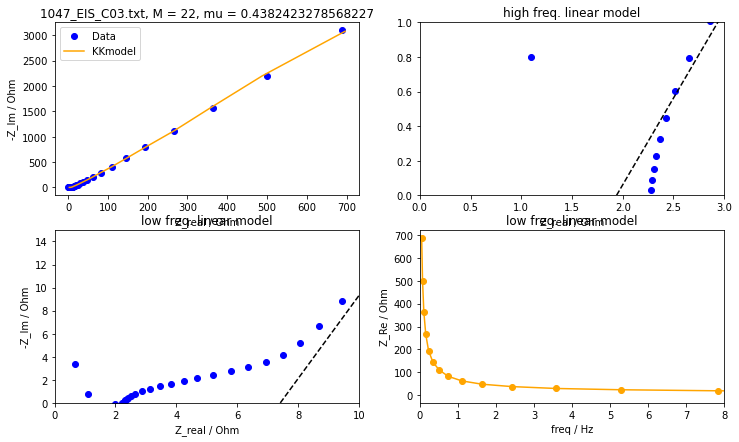

In [6]:
#Quick Nyquist visualisation to assess basic parameters and do KK fit

fig, ax = plt.subplots(2, 2, figsize=(12,7))
lns1 = ax[0, 0].plot(Z.real, -Z.imag, color='blue', marker ='o', linestyle ='None', label = "Data") 
lns2 = ax[0, 0].plot(Z_linKK.real, -Z_linKK.imag, color='orange', linestyle ='-', label = "KKmodel") 
ax[0, 0].set_ylabel('-Z_Im / Ohm')
ax[0, 0].set_xlabel('Z_real / Ohm')

#Zoom into early semi-circles

xlim = 10
xlim2 = R_lowf - 50
ylim = 25

#ax[0, 0].set_xlim(0, xlim)
#ax[0, 0].set_ylim(0, ylim)

ax[0, 0].set_title(str(data)+', M = '+str(M)+', mu = '+str(mu))
ax[0, 1].set_title('high freq. linear model')
ax[1, 0].set_title('low freq. linear model')
ax[1, 1].set_title('low freq. linear model')

lns3 = ax[0,1].plot(Z.real, -Z.imag, color='blue', marker ='o', linestyle ='None', label = "Data")
lns4 = ax[0,1].plot(Z_linKK.real, -Z_linKK.imag, color='orange', linestyle ='-', label = "KKmodel")
lns5 = ax[0,1].plot(Z_Re_highf_fit, -Z_Im_highf_fit, color='black', linestyle ='--', label = "linear")
ax[0,1].set_xlabel('Z_real / Ohm')

ax[0,1].set_xlim(0, 3)
ax[0,1].set_ylim(0, 1)

lns6 = ax[1,0].plot(Z.real, -Z.imag, color='blue', linestyle ='None', marker ='o', label = "Z-real") 
lns7 = ax[1,0].plot(Z_Re_lowf_fit, -Z_Im_lowf_fit, color='black', linestyle ='--', label = "linear")
ax[1,0].set_ylabel('-Z_Im / Ohm')
ax[1,0].set_xlabel('Z_real / Ohm')
ax[1, 0].set_xlim(xlim2, max(Z.real))
ax[1,0].set_xlim(0, 10)
ax[1,0].set_ylim(0, 15)

lns8 = ax[1,1].plot(freq, Z.real, color='orange', marker ='o', label = "Z-real") 
ax[1,1].set_xlim(0, 8)
ax[1,1].set_ylabel('Z_Re / Ohm')
ax[1,1].set_xlabel('freq / Hz')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax[0, 0].legend(lns, labs, loc='upper left')

plt.show()

In [7]:
#Define circuit element and build starting guess model
#Transmission line model TLMQ: Rion, Qs, gamma = p[0], p[1], p[2]



#Fit 1 based on reduced frequency range
circuit1 = 'R0-TLMQ0'
initial_guess1 = [0.0202, 0.723]
constant1 = {'R0':14.5, 'TLMQ0_0':70.6}
circuit1 = CustomCircuit(circuit1, initial_guess=initial_guess1,
                        constants = constant1 )



#Fit 2 based on reduced frequency range
circuit2 = 'R0-TLMQ0'
initial_guess2 = [0.7, 3.5, 0.0091, 0.932]
#constant2 = {'R0':0.7, 'TLMQ0_0':3.5}
circuit2 = CustomCircuit(circuit2, initial_guess=initial_guess2)#,
                        #constants = constant2 )



#Circuit element and model for trial limited model, look at above fit and adjust manually for improved fit
####simulation circuit 1 - all values to be set upon inspecting trial fit

Rion1 = 3.6
Q1 = 0.0091
alpha1 = 0.72

circuit3 = 'R0-TLMQ0'
constant3 = {'R0':0.6, 'TLMQ0_0':Rion1, 'TLMQ0_1':Q1, 'TLMQ0_2':alpha1 }
circuit3 = CustomCircuit(circuit3, 
                         constants = constant3)


####simulation circuit 2 - all values to be set upon inspecting trial fit

Rion2 = 3
Q2= 0.0091
alpha2 = 0.72

circuit4 = 'R0-TLMQ0'
constant4 = {'R0':0.6, 'TLMQ0_0':Rion2, 'TLMQ0_1':Q2, 'TLMQ0_2':alpha2 }
circuit4 = CustomCircuit(circuit4, constants = constant4)


In [22]:
#Crop data to only retain part of data to fit

freqmin1 = 0.1
freqmax1 = 20000

freq1, Z1 = preprocessing.cropFrequencies(freq, Z, freqmin=freqmin1, freqmax=freqmax1)

In [23]:
#Fit EIS model for full data

circuit1.fit(freq, Z)
Z_fit1 = circuit1.predict(freq)

Z_sim1 = circuit3.predict(freq)
Z_sim2 = circuit4.predict(freq)

circuit2.fit(freq1, Z1)
Z_fit2 = circuit2.predict(freq1)


C:\Users\SunyhikAhn\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:311: RuntimeWarning: overflow encountered in tanh
  Z = np.sqrt(Rion/Zs)/np.tanh(np.sqrt(Rion*Zs))
C:\Users\SunyhikAhn\anaconda3\lib\site-packages\impedance\models\circuits\circuits.py:166: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


In [24]:
#Tease out and calculate values for phase angle and Z_mod (to avoid using built in visualise package)

Z_mod_exp = np.sqrt((Z.real*Z.real) + (Z.imag*Z.imag))
phase_exp = np.arctan(Z.imag/Z.real)

Z_mod_fit1 = np.sqrt((Z_fit1.real*Z_fit1.real) + (Z_fit1.imag*Z_fit1.imag))
phase_fit1 = np.arctan(Z_fit1.imag/Z_fit1.real)

Z_mod_fit2 = np.sqrt((Z_fit2.real*Z_fit2.real) + (Z_fit2.imag*Z_fit2.imag))
phase_fit2 = np.arctan(Z_fit2.imag/Z_fit2.real)

Z_mod_sim1 = np.sqrt((Z_sim1.real*Z_sim1.real) + (Z_sim1.imag*Z_sim1.imag))
phase_sim1 = np.arctan(Z_sim1.imag/Z_sim1.real)

Z_mod_sim2 = np.sqrt((Z_sim2.real*Z_sim2.real) + (Z_sim2.imag*Z_sim2.imag))
phase_sim2 = np.arctan(Z_sim2.imag/Z_sim2.real)

In [25]:
#Save values into dataframe and export

df_res = pd.DataFrame()

df_res['freq_exp'] = freq
df_res['Z_Re_exp'] = Z.real
df_res['nZ_Im_exp'] = Z.imag
df_res['Z_mod_exp'] = Z_mod_exp
df_res['phase_exp'] = phase_exp

df_res['Z_Re_fit'] = Z_fit1.real
df_res['nZ_Im_fit'] = -Z_fit1.imag
df_res['Z_mod_fit'] = Z_mod_fit1
df_res['phase_fit'] = phase_fit1



C:\Users\SUNYHI~1\AppData\Local\Temp/ipykernel_1484/2038070256.py:60: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000197C407B9D0> has a label of '_line3' which cannot be automatically added to the legend.
  ax['A)'].legend(lns, labs, loc='lower right')
C:\Users\SUNYHI~1\AppData\Local\Temp/ipykernel_1484/2038070256.py:62: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000197C407B9D0> has a label of '_line3' which cannot be automatically added to the legend.
  ax['C)'].legend(lns, labs, loc='upper right')
C:\Users\SUNYHI~1\AppData\Local\Temp/ipykernel_1484/2038070256.py:63: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000197C407B9D0> has a label of '_line3' which cannot be automatically added to the legend.
  ax['D)'].legend(lns, labs, loc='upper right')


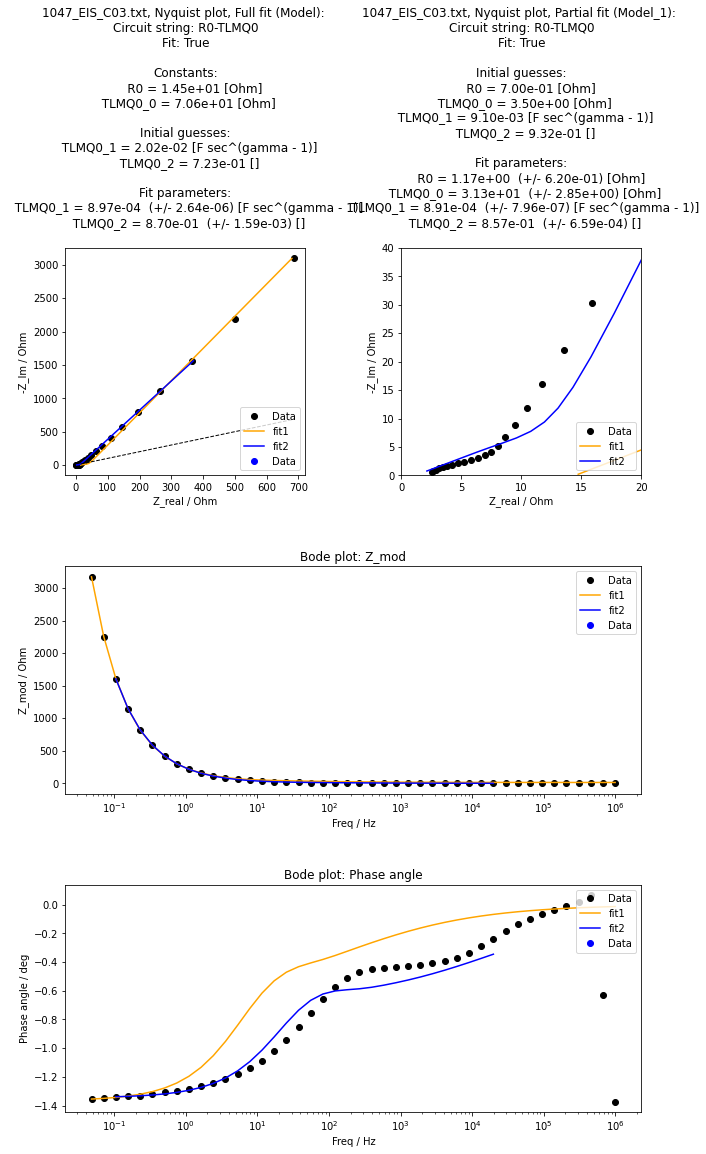

In [27]:
#Plot data and model

fig, ax = plt.subplot_mosaic([['A)','B)'], ['C)', 'C)'], ['D)', 'D)']], figsize=(8,15))

#lns1 = ax.plot(df.Re_Z_Ohm, -df.Im_Z_Ohm, color='blue', marker ='o') 
lns1 = ax['A)'].plot(Z.real, -Z.imag, color='black', marker ='o', linestyle ='None', label = "Data") 
lns2 = ax['A)'].plot(Z_fit1.real, -Z_fit1.imag, color='orange', linestyle ='-', label = "fit1") 
lns2a = ax['A)'].plot(Z_fit2.real, -Z_fit2.imag, color='blue', linestyle ='-', label = "fit2") 
lns3a = ax['A)'].plot(Z_fit1.real, Z_fit1.real, color='black', linewidth=1, linestyle ='--')
#lns3 = ax['A)'].plot(Z_sim1.real, -Z_sim1.imag, color='red', linestyle ='--', label = 'sim1') 
#lns14a = ax['A)'].plot(Z_sim2.real, -Z_sim2.imag, color='green', linestyle ='-', label = 'sim2') 


lns10 = ax['B)'].plot(Z1.real, -Z1.imag, color='black', marker ='o', linestyle ='None', label = "Data") 
lns13 = ax['B)'].plot(Z_fit1.real, -Z_fit1.imag, color='orange', linestyle ='-', label = "fit1" ) 
lns13a = ax['B)'].plot(Z_fit2.real, -Z_fit2.imag, color='blue', linestyle ='-', label = "fit2" )
#lns12 = ax['B)'].plot(Z_sim1.real, -Z_sim1.imag, color='red', linestyle ='--', label = 'sim1') 
#lns14 = ax['B)'].plot(Z_sim2.real, -Z_sim2.imag, color='green', linestyle ='-', label = 'sim2') 

lns4 = ax['C)'].plot(freq, Z_mod_exp, color='black', marker ='o', linestyle ='None', label = "Data") 
lns5 = ax['C)'].plot(freq, Z_mod_fit1, color='orange', linestyle ='-', label = "fit1") 
lns5a = ax['C)'].plot(freq1, Z_mod_fit2, color='blue', linestyle ='-', label = "fit2") 
#lns6 = ax['C)'].plot(freq, Z_mod_sim1, color='red', linestyle ='-', label = "sim1") 
#lns6a = ax['C)'].plot(freq, Z_mod_sim2, color='green', linestyle ='-', label = "sim2") 

lns7 = ax['D)'].plot(freq, phase_exp, color='black', marker ='o', linestyle ='None', label = "Data") 
lns8 = ax['D)'].plot(freq, phase_fit1, color='orange', linestyle ='-', label = "fit1")
lns8a = ax['D)'].plot(freq1, phase_fit2, color='blue', linestyle ='-', label = "fit2")
#lns9 = ax['D)'].plot(freq, phase_sim1, color='red', linestyle ='-', label = "sim1")
#lns6 = ax['D)'].plot(freq, phase_sim2, color='green', linestyle ='-', label = "sim2") 

ax['A)'].set_title(str(data)+', Nyquist plot, Full fit (Model): '+str(circuit1))
ax['A)'].set_ylabel('-Z_Im / Ohm')
ax['A)'].set_xlabel('Z_real / Ohm')
#ax['A)'].set_xlim(2, 15)
#ax['A)'].set_ylim(0, 40)

ax['B)'].set_title(str(data)+', Nyquist plot, Partial fit (Model_1): '+str(circuit2))
ax['B)'].set_ylabel('-Z_Im / Ohm')
ax['B)'].set_xlabel('Z_real / Ohm')
ax['B)'].set_xlim(0, 20)
ax['B)'].set_ylim(0, 40)

ax['C)'].set_title('Bode plot: Z_mod')
ax['C)'].set_xlabel('Freq / Hz')
ax['C)'].set_ylabel('Z_mod / Ohm')
ax['C)'].set_xscale('log')

ax['D)'].set_title('Bode plot: Phase angle')
ax['D)'].set_xlabel('Freq / Hz')
ax['D)'].set_ylabel('Phase angle / deg')
ax['D)'].set_xscale('log')


lns = lns1 + lns2 + lns2a + lns3 + lns3a 
lnsa = lns10 + lns13 + lns13a 

labs = [l.get_label() for l in lns]
labsa = [l.get_label() for l in lnsa]
ax['A)'].legend(lns, labs, loc='lower right')
ax['B)'].legend(lnsa, labsa, loc='lower right')
ax['C)'].legend(lns, labs, loc='upper right')
ax['D)'].legend(lns, labs, loc='upper right')

# set the spacing between subplots
plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [21]:
print(circuit2)


Circuit string: R0-TLMQ0
Fit: True

Initial guesses:
     R0 = 7.00e-01 [Ohm]
  TLMQ0_0 = 3.50e+00 [Ohm]
  TLMQ0_1 = 9.10e-03 [F sec^(gamma - 1)]
  TLMQ0_2 = 9.32e-01 []

Fit parameters:
     R0 = 7.90e-01  (+/- 8.22e-01) [Ohm]
  TLMQ0_0 = 3.59e+01  (+/- 3.61e+00) [Ohm]
  TLMQ0_1 = 8.90e-04  (+/- 7.50e-07) [F sec^(gamma - 1)]
  TLMQ0_2 = 8.59e-01  (+/- 5.77e-04) []



In [14]:
circuit2.get_param_names()

(['R0', 'TLMQ0_0', 'TLMQ0_1', 'TLMQ0_2'],
 ['Ohm', 'Ohm', 'F sec^(gamma - 1)', ''])